In [1]:
import torch
import argparse
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Attention_block(nn.Module):
    """
    Attention Block
    """
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            # nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            # nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            # nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Attention_Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Attention_Unet, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.Att6 = Attention_block(F_g=512, F_l=512, F_int=256)        
        self.conv6 = DoubleConv(1024, 512)
        
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.Att7 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.conv7 = DoubleConv(512, 256)
        
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.Att8 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.conv8 = DoubleConv(256, 128)
        
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.Att9 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.conv9 = DoubleConv(128, 64)
        
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        
        up_6= self.up6(c5)
        att6 = self.Att6(g=up_6, x=c4)
        merge6 = torch.cat([att6, up_6], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        att7 = self.Att7(g=up_7, x=c3)
        merge7 = torch.cat([att7, up_7], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        att8 = self.Att8(g=up_8, x=c2)
        merge8 = torch.cat([att8, up_8], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        att9 = self.Att9(g=up_9, x=c1)
        merge9=torch.cat([att9, up_9],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

In [12]:
def make_dataset(root):
    imgs=[]
    n=len(os.listdir(root))//2
    for i in range(n):
        img=os.path.join(root,"%03d.png"%i)
        mask=os.path.join(root,"%03d_mask.png"%i)
        imgs.append((img,mask))
    return imgs


class LiverDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [13]:
x_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
])

In [14]:
def train_model(model, criterion, optimizer, dataload, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [15]:
model = Attention_Unet(3, 1).to(device)
batch_size = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
liver_dataset = LiverDataset("u_net_liver/data/data/train",transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_model(model, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 0/9
----------
1/400,train_loss:0.769
2/400,train_loss:0.688
3/400,train_loss:0.605
4/400,train_loss:0.584
5/400,train_loss:0.540
6/400,train_loss:0.551
7/400,train_loss:0.637
8/400,train_loss:0.579
9/400,train_loss:0.608
10/400,train_loss:0.502
11/400,train_loss:0.491
12/400,train_loss:0.514
13/400,train_loss:0.536
14/400,train_loss:0.492
15/400,train_loss:0.545
16/400,train_loss:0.494
17/400,train_loss:0.510
18/400,train_loss:0.521
19/400,train_loss:0.481
20/400,train_loss:0.432
21/400,train_loss:0.430
22/400,train_loss:0.484
23/400,train_loss:0.407
24/400,train_loss:0.468
25/400,train_loss:0.408
26/400,train_loss:0.476
27/400,train_loss:0.448
28/400,train_loss:0.439
29/400,train_loss:0.401
30/400,train_loss:0.404
31/400,train_loss:0.388
32/400,train_loss:0.402
33/400,train_loss:0.418
34/400,train_loss:0.367
35/400,train_loss:0.389
36/400,train_loss:0.355
37/400,train_loss:0.352
38/400,train_loss:0.420
39/400,train_loss:0.356
40/400,train_loss:0.353
41/400,train_loss:0.335
42/4

333/400,train_loss:0.083
334/400,train_loss:0.112
335/400,train_loss:0.102
336/400,train_loss:0.092
337/400,train_loss:0.099
338/400,train_loss:0.073
339/400,train_loss:0.076
340/400,train_loss:0.057
341/400,train_loss:0.080
342/400,train_loss:0.078
343/400,train_loss:0.075
344/400,train_loss:0.066
345/400,train_loss:0.073
346/400,train_loss:0.055
347/400,train_loss:0.068
348/400,train_loss:0.044
349/400,train_loss:0.069
350/400,train_loss:0.048
351/400,train_loss:0.041
352/400,train_loss:0.039
353/400,train_loss:0.041
354/400,train_loss:0.054
355/400,train_loss:0.054
356/400,train_loss:0.043
357/400,train_loss:0.035
358/400,train_loss:0.030
359/400,train_loss:0.041
360/400,train_loss:0.030
361/400,train_loss:0.045
362/400,train_loss:0.030
363/400,train_loss:0.057
364/400,train_loss:0.038
365/400,train_loss:0.029
366/400,train_loss:0.044
367/400,train_loss:0.038
368/400,train_loss:0.092
369/400,train_loss:0.052
370/400,train_loss:0.066
371/400,train_loss:0.049
372/400,train_loss:0.077


264/400,train_loss:0.022
265/400,train_loss:0.016
266/400,train_loss:0.011
267/400,train_loss:0.035
268/400,train_loss:0.027
269/400,train_loss:0.025
270/400,train_loss:0.040
271/400,train_loss:0.014
272/400,train_loss:0.030
273/400,train_loss:0.011
274/400,train_loss:0.029
275/400,train_loss:0.030
276/400,train_loss:0.016
277/400,train_loss:0.021
278/400,train_loss:0.031
279/400,train_loss:0.037
280/400,train_loss:0.018
281/400,train_loss:0.044
282/400,train_loss:0.023
283/400,train_loss:0.027
284/400,train_loss:0.019
285/400,train_loss:0.011
286/400,train_loss:0.017
287/400,train_loss:0.029
288/400,train_loss:0.021
289/400,train_loss:0.011
290/400,train_loss:0.020
291/400,train_loss:0.009
292/400,train_loss:0.011
293/400,train_loss:0.022
294/400,train_loss:0.027
295/400,train_loss:0.031
296/400,train_loss:0.029
297/400,train_loss:0.032
298/400,train_loss:0.009
299/400,train_loss:0.011
300/400,train_loss:0.013
301/400,train_loss:0.018
302/400,train_loss:0.028
303/400,train_loss:0.026


195/400,train_loss:0.011
196/400,train_loss:0.017
197/400,train_loss:0.014
198/400,train_loss:0.018
199/400,train_loss:0.009
200/400,train_loss:0.011
201/400,train_loss:0.016
202/400,train_loss:0.008
203/400,train_loss:0.009
204/400,train_loss:0.026
205/400,train_loss:0.018
206/400,train_loss:0.015
207/400,train_loss:0.025
208/400,train_loss:0.014
209/400,train_loss:0.024
210/400,train_loss:0.018
211/400,train_loss:0.016
212/400,train_loss:0.013
213/400,train_loss:0.016
214/400,train_loss:0.011
215/400,train_loss:0.007
216/400,train_loss:0.016
217/400,train_loss:0.044
218/400,train_loss:0.020
219/400,train_loss:0.007
220/400,train_loss:0.037
221/400,train_loss:0.023
222/400,train_loss:0.009
223/400,train_loss:0.021
224/400,train_loss:0.024
225/400,train_loss:0.021
226/400,train_loss:0.024
227/400,train_loss:0.026
228/400,train_loss:0.022
229/400,train_loss:0.021
230/400,train_loss:0.021
231/400,train_loss:0.009
232/400,train_loss:0.021
233/400,train_loss:0.011
234/400,train_loss:0.018


126/400,train_loss:0.019
127/400,train_loss:0.006
128/400,train_loss:0.012
129/400,train_loss:0.034
130/400,train_loss:0.015
131/400,train_loss:0.022
132/400,train_loss:0.006
133/400,train_loss:0.012
134/400,train_loss:0.019
135/400,train_loss:0.021
136/400,train_loss:0.013
137/400,train_loss:0.009
138/400,train_loss:0.017
139/400,train_loss:0.011
140/400,train_loss:0.005
141/400,train_loss:0.015
142/400,train_loss:0.014
143/400,train_loss:0.008
144/400,train_loss:0.009
145/400,train_loss:0.007
146/400,train_loss:0.020
147/400,train_loss:0.005
148/400,train_loss:0.026
149/400,train_loss:0.017
150/400,train_loss:0.017
151/400,train_loss:0.019
152/400,train_loss:0.006
153/400,train_loss:0.012
154/400,train_loss:0.020
155/400,train_loss:0.019
156/400,train_loss:0.011
157/400,train_loss:0.018
158/400,train_loss:0.007
159/400,train_loss:0.015
160/400,train_loss:0.006
161/400,train_loss:0.015
162/400,train_loss:0.042
163/400,train_loss:0.010
164/400,train_loss:0.012
165/400,train_loss:0.012


55/400,train_loss:0.007
56/400,train_loss:0.013
57/400,train_loss:0.014
58/400,train_loss:0.015
59/400,train_loss:0.007
60/400,train_loss:0.009
61/400,train_loss:0.014
62/400,train_loss:0.009
63/400,train_loss:0.008
64/400,train_loss:0.013
65/400,train_loss:0.004
66/400,train_loss:0.007
67/400,train_loss:0.005
68/400,train_loss:0.008
69/400,train_loss:0.011
70/400,train_loss:0.007
71/400,train_loss:0.014
72/400,train_loss:0.018
73/400,train_loss:0.007
74/400,train_loss:0.009
75/400,train_loss:0.011
76/400,train_loss:0.010
77/400,train_loss:0.008
78/400,train_loss:0.010
79/400,train_loss:0.016
80/400,train_loss:0.006
81/400,train_loss:0.019
82/400,train_loss:0.005
83/400,train_loss:0.006
84/400,train_loss:0.014
85/400,train_loss:0.014
86/400,train_loss:0.008
87/400,train_loss:0.011
88/400,train_loss:0.007
89/400,train_loss:0.009
90/400,train_loss:0.015
91/400,train_loss:0.016
92/400,train_loss:0.019
93/400,train_loss:0.006
94/400,train_loss:0.016
95/400,train_loss:0.016
96/400,train_los

385/400,train_loss:0.021
386/400,train_loss:0.015
387/400,train_loss:0.009
388/400,train_loss:0.015
389/400,train_loss:0.043
390/400,train_loss:0.014
391/400,train_loss:0.021
392/400,train_loss:0.037
393/400,train_loss:0.028
394/400,train_loss:0.027
395/400,train_loss:0.015
396/400,train_loss:0.031
397/400,train_loss:0.027
398/400,train_loss:0.029
399/400,train_loss:0.048
400/400,train_loss:0.028
epoch 4 loss:0.018
Epoch 5/9
----------
1/400,train_loss:0.024
2/400,train_loss:0.025
3/400,train_loss:0.019
4/400,train_loss:0.022
5/400,train_loss:0.019
6/400,train_loss:0.036
7/400,train_loss:0.018
8/400,train_loss:0.010
9/400,train_loss:0.010
10/400,train_loss:0.020
11/400,train_loss:0.024
12/400,train_loss:0.012
13/400,train_loss:0.009
14/400,train_loss:0.016
15/400,train_loss:0.006
16/400,train_loss:0.021
17/400,train_loss:0.020
18/400,train_loss:0.046
19/400,train_loss:0.061
20/400,train_loss:0.011
21/400,train_loss:0.052
22/400,train_loss:0.009
23/400,train_loss:0.048
24/400,train_loss

316/400,train_loss:0.011
317/400,train_loss:0.009
318/400,train_loss:0.005
319/400,train_loss:0.011
320/400,train_loss:0.004
321/400,train_loss:0.023
322/400,train_loss:0.011
323/400,train_loss:0.004
324/400,train_loss:0.006
325/400,train_loss:0.018
326/400,train_loss:0.005
327/400,train_loss:0.011
328/400,train_loss:0.008
329/400,train_loss:0.010
330/400,train_loss:0.013
331/400,train_loss:0.006
332/400,train_loss:0.015
333/400,train_loss:0.004
334/400,train_loss:0.004
335/400,train_loss:0.014
336/400,train_loss:0.004
337/400,train_loss:0.007
338/400,train_loss:0.007
339/400,train_loss:0.009
340/400,train_loss:0.016
341/400,train_loss:0.014
342/400,train_loss:0.010
343/400,train_loss:0.009
344/400,train_loss:0.008
345/400,train_loss:0.011
346/400,train_loss:0.010
347/400,train_loss:0.014
348/400,train_loss:0.014
349/400,train_loss:0.009
350/400,train_loss:0.006
351/400,train_loss:0.015
352/400,train_loss:0.010
353/400,train_loss:0.005
354/400,train_loss:0.015
355/400,train_loss:0.010


247/400,train_loss:0.009
248/400,train_loss:0.007
249/400,train_loss:0.008
250/400,train_loss:0.017
251/400,train_loss:0.012
252/400,train_loss:0.010
253/400,train_loss:0.014
254/400,train_loss:0.008
255/400,train_loss:0.006
256/400,train_loss:0.005
257/400,train_loss:0.019
258/400,train_loss:0.009
259/400,train_loss:0.011
260/400,train_loss:0.014
261/400,train_loss:0.014
262/400,train_loss:0.008
263/400,train_loss:0.013
264/400,train_loss:0.010
265/400,train_loss:0.011
266/400,train_loss:0.006
267/400,train_loss:0.008
268/400,train_loss:0.004
269/400,train_loss:0.007
270/400,train_loss:0.010
271/400,train_loss:0.010
272/400,train_loss:0.008
273/400,train_loss:0.005
274/400,train_loss:0.013
275/400,train_loss:0.012
276/400,train_loss:0.013
277/400,train_loss:0.013
278/400,train_loss:0.011
279/400,train_loss:0.004
280/400,train_loss:0.004
281/400,train_loss:0.009
282/400,train_loss:0.006
283/400,train_loss:0.006
284/400,train_loss:0.012
285/400,train_loss:0.009
286/400,train_loss:0.008


178/400,train_loss:0.015
179/400,train_loss:0.015
180/400,train_loss:0.004
181/400,train_loss:0.008
182/400,train_loss:0.017
183/400,train_loss:0.008
184/400,train_loss:0.009
185/400,train_loss:0.008
186/400,train_loss:0.010
187/400,train_loss:0.004
188/400,train_loss:0.011
189/400,train_loss:0.008
190/400,train_loss:0.013
191/400,train_loss:0.011
192/400,train_loss:0.004
193/400,train_loss:0.013
194/400,train_loss:0.010
195/400,train_loss:0.004
196/400,train_loss:0.004
197/400,train_loss:0.004
198/400,train_loss:0.009
199/400,train_loss:0.009
200/400,train_loss:0.007
201/400,train_loss:0.007
202/400,train_loss:0.011
203/400,train_loss:0.011
204/400,train_loss:0.009
205/400,train_loss:0.013
206/400,train_loss:0.010
207/400,train_loss:0.007
208/400,train_loss:0.012
209/400,train_loss:0.005
210/400,train_loss:0.006
211/400,train_loss:0.004
212/400,train_loss:0.003
213/400,train_loss:0.008
214/400,train_loss:0.013
215/400,train_loss:0.009
216/400,train_loss:0.011
217/400,train_loss:0.004


109/400,train_loss:0.010
110/400,train_loss:0.014
111/400,train_loss:0.012
112/400,train_loss:0.008
113/400,train_loss:0.007
114/400,train_loss:0.007
115/400,train_loss:0.011
116/400,train_loss:0.008
117/400,train_loss:0.013
118/400,train_loss:0.004
119/400,train_loss:0.008
120/400,train_loss:0.014
121/400,train_loss:0.004
122/400,train_loss:0.011
123/400,train_loss:0.007
124/400,train_loss:0.006
125/400,train_loss:0.004
126/400,train_loss:0.008
127/400,train_loss:0.006
128/400,train_loss:0.004
129/400,train_loss:0.003
130/400,train_loss:0.011
131/400,train_loss:0.006
132/400,train_loss:0.003
133/400,train_loss:0.010
134/400,train_loss:0.006
135/400,train_loss:0.005
136/400,train_loss:0.007
137/400,train_loss:0.009
138/400,train_loss:0.011
139/400,train_loss:0.005
140/400,train_loss:0.005
141/400,train_loss:0.009
142/400,train_loss:0.006
143/400,train_loss:0.006
144/400,train_loss:0.007
145/400,train_loss:0.008
146/400,train_loss:0.011
147/400,train_loss:0.003
148/400,train_loss:0.009


37/400,train_loss:0.005
38/400,train_loss:0.006
39/400,train_loss:0.011
40/400,train_loss:0.014
41/400,train_loss:0.011
42/400,train_loss:0.007
43/400,train_loss:0.004
44/400,train_loss:0.005
45/400,train_loss:0.012
46/400,train_loss:0.010
47/400,train_loss:0.006
48/400,train_loss:0.006
49/400,train_loss:0.007
50/400,train_loss:0.004
51/400,train_loss:0.006
52/400,train_loss:0.009
53/400,train_loss:0.010
54/400,train_loss:0.014
55/400,train_loss:0.005
56/400,train_loss:0.011
57/400,train_loss:0.009
58/400,train_loss:0.012
59/400,train_loss:0.014
60/400,train_loss:0.009
61/400,train_loss:0.012
62/400,train_loss:0.004
63/400,train_loss:0.011
64/400,train_loss:0.008
65/400,train_loss:0.008
66/400,train_loss:0.011
67/400,train_loss:0.011
68/400,train_loss:0.008
69/400,train_loss:0.006
70/400,train_loss:0.005
71/400,train_loss:0.006
72/400,train_loss:0.011
73/400,train_loss:0.013
74/400,train_loss:0.005
75/400,train_loss:0.007
76/400,train_loss:0.013
77/400,train_loss:0.015
78/400,train_los

368/400,train_loss:0.009
369/400,train_loss:0.004
370/400,train_loss:0.004
371/400,train_loss:0.006
372/400,train_loss:0.009
373/400,train_loss:0.007
374/400,train_loss:0.006
375/400,train_loss:0.008
376/400,train_loss:0.004
377/400,train_loss:0.012
378/400,train_loss:0.007
379/400,train_loss:0.008
380/400,train_loss:0.005
381/400,train_loss:0.004
382/400,train_loss:0.012
383/400,train_loss:0.007
384/400,train_loss:0.010
385/400,train_loss:0.006
386/400,train_loss:0.007
387/400,train_loss:0.009
388/400,train_loss:0.004
389/400,train_loss:0.006
390/400,train_loss:0.003
391/400,train_loss:0.008
392/400,train_loss:0.006
393/400,train_loss:0.004
394/400,train_loss:0.004
395/400,train_loss:0.009
396/400,train_loss:0.003
397/400,train_loss:0.008
398/400,train_loss:0.004
399/400,train_loss:0.010
400/400,train_loss:0.008
epoch 9 loss:0.008


Attention_Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2

In [16]:
model = model.cpu()

In [17]:
liver_dataset = LiverDataset("u_net_liver/data/data/val", transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=1)
# model.eval()

In [18]:
model.eval()

Attention_Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2

In [19]:
def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    import numpy as np
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

In [20]:
IoU = 0
n = 0
with torch.no_grad():
    for x, target in dataloaders:
        n = n + 1
        y = model(x)
        y_pred = torch.squeeze(y).numpy() > 0.5
        y_true = torch.squeeze(target).numpy()
        # print(meanIOU_per_image(y_pred, y_true))
        IoU = IoU + meanIOU_per_image(y_pred, y_true)
print(IoU/n)

0.7990141111690123


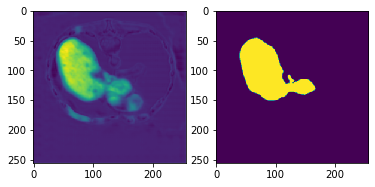

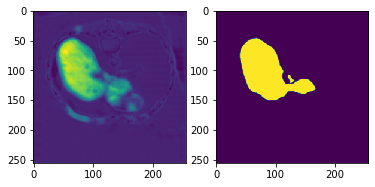

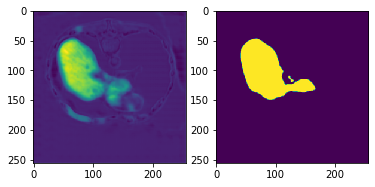

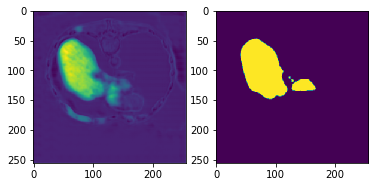

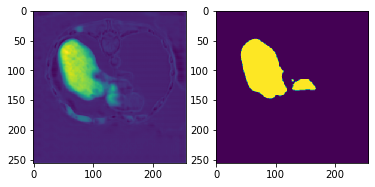

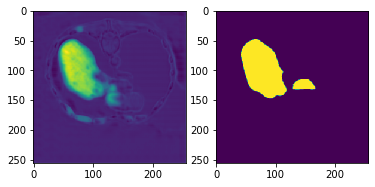

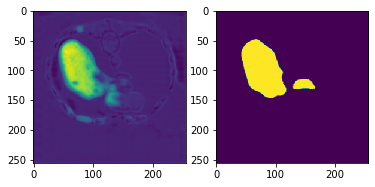

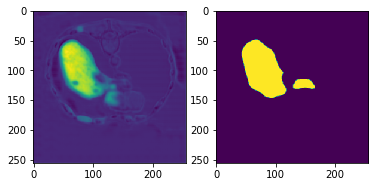

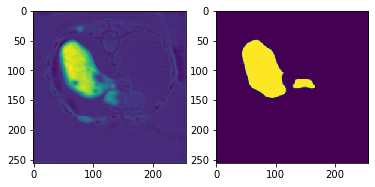

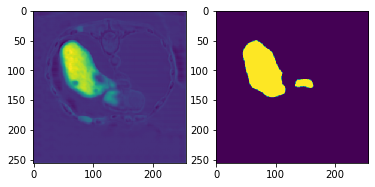

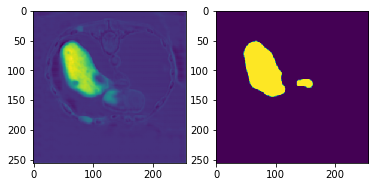

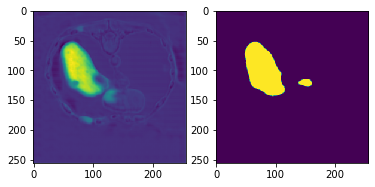

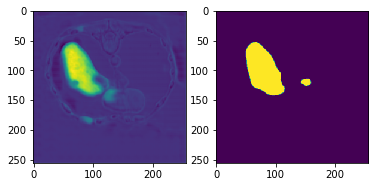

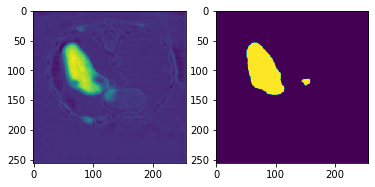

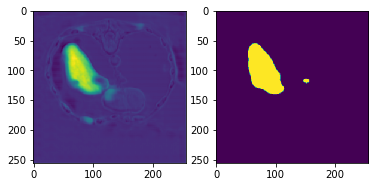

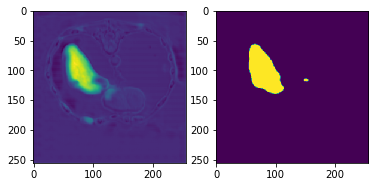

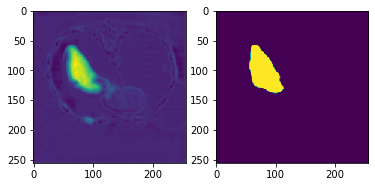

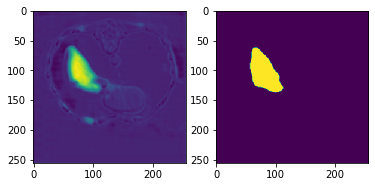

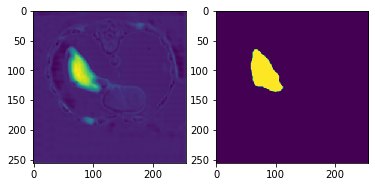

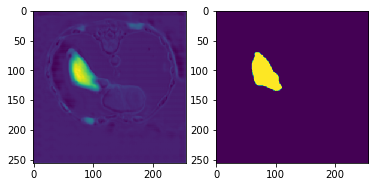

In [21]:
plt.ion()
with torch.no_grad():
    for x,label in dataloaders:
        y=model(x)
        img_y=torch.squeeze(y).numpy()
        img_label = torch.squeeze(label).numpy()  
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img_y)
        plt.subplot(1,2,2)
        plt.imshow(img_label)
        plt.pause(0.01)
    plt.show()